# YouTube, desktop, фильтрованные трассы

In [1]:
import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

**Подгружаем таблицу с нашими данными**

In [2]:
data = pd.read_csv('data.csv')
data

,Unnamed: 0,Video_number,Density_burst,Density_throttling,Quality
0,0,1,2.575873e+07,1.585146e+06,2160
1,1,2,2.093498e+07,1.511580e+06,2160
2,2,3,2.473638e+07,2.061731e+06,2160
3,3,4,1.771628e+07,2.028604e+06,2160
4,4,5,9.715531e+06,8.426243e+05,2160
...,...,...,...,...,...
145,145,21,2.209689e+06,3.304367e+04,360
146,146,22,2.285067e+06,3.488049e+04,360
147,147,23,1.595180e+06,2.678645e+04,360
148,148,24,2.364400e+06,3.232247e+04,360


In [3]:
data = data.drop(columns=['Unnamed: 0', 'Video_number'])
data

,Density_burst,Density_throttling,Quality
0,2.575873e+07,1.585146e+06,2160
1,2.093498e+07,1.511580e+06,2160
2,2.473638e+07,2.061731e+06,2160
3,1.771628e+07,2.028604e+06,2160
4,9.715531e+06,8.426243e+05,2160
...,...,...,...
145,2.209689e+06,3.304367e+04,360
146,2.285067e+06,3.488049e+04,360
147,1.595180e+06,2.678645e+04,360
148,2.364400e+06,3.232247e+04,360


**Посмотрим на данные наглядно**

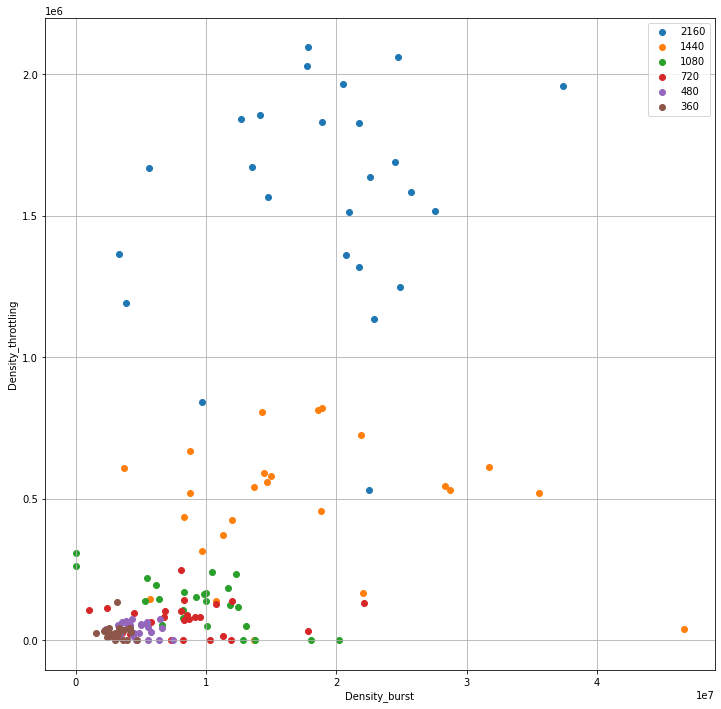

In [63]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

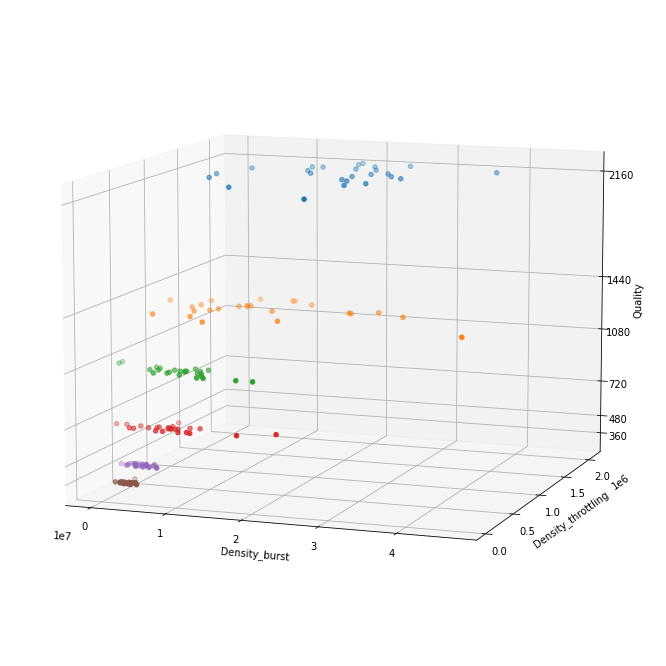

In [5]:
fig_3d = plt.figure(figsize=(12, 12))
ax = fig_3d.add_subplot(projection='3d')

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    z = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
            z.append(quality)
    ax.scatter(x, y, z)
    
ax.set_xlabel('Density_burst')
ax.set_ylabel('Density_throttling')
ax.set_zlabel('Quality')

ax.view_init(10,-70)

ax.set_zticks([360, 480, 720, 1080, 1440, 2160])

plt.grid(True)

plt.show()

**Перемешаем строки**

In [6]:
data_shuffled = shuffle(data)
data_shuffled

,Density_burst,Density_throttling,Quality
78,8.273887e+06,6.600000e+00,720
6,1.778985e+07,2.094851e+06,2160
103,4.627552e+06,3.300000e+00,480
109,4.435030e+06,1.553000e+04,480
11,3.342868e+06,1.363895e+06,2160
...,...,...,...
110,4.870285e+06,2.587146e+04,480
48,1.497463e+07,5.805906e+05,1440
75,1.189955e+07,2.869565e+00,720
0,2.575873e+07,1.585146e+06,2160


**Пробуем обычный KNN**

In [52]:
X = data_shuffled[['Density_burst', 'Density_throttling']]
y = data_shuffled['Quality']

best_score = 0.0
i_best_score = 0
for i in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
    n_spaces = 1 - i // 10
    print(i, ' ' * n_spaces, scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        i_best_score = i

print("\nЛучший резульат:\nn =", i_best_score, "\naccuracy =", best_score)

1   0.5199999999999999
2   0.5
3   0.5
4   0.48
5   0.4333333333333333
6   0.4999999999999999
7   0.49333333333333335
8   0.47999999999999987
9   0.5
10  0.48666666666666664
11  0.4933333333333333
12  0.4999999999999999
13  0.4933333333333333
14  0.49333333333333335
15  0.49333333333333335
16  0.4666666666666667
17  0.47333333333333333
18  0.45999999999999996
19  0.45999999999999996
20  0.4533333333333333
21  0.45999999999999996
22  0.47333333333333333
23  0.4600000000000001
24  0.47333333333333333
25  0.47333333333333333
26  0.49333333333333335
27  0.47333333333333333
28  0.4866666666666667
29  0.47333333333333333

Лучший резульат:
n = 1 
accuracy = 0.5199999999999999


**Нужно нормализовать данные**

In [9]:
data_norm = data_shuffled.copy()

for column in ['Density_burst', 'Density_throttling']:
    data_norm[column] = ((data_norm[column] - data_norm[column].min()) /
                            (data_norm[column].max() - data_norm[column].min()))
    
data_norm

,Density_burst,Density_throttling,Quality
78,0.177235,1.780766e-06,720
6,0.381080,1.000000e+00,2160
103,0.099126,2.054730e-07,480
109,0.095001,7.412056e-03,480
11,0.071606,6.510700e-01,2160
...,...,...,...
110,0.104325,1.234867e-02,480
48,0.320774,2.771503e-01,1440
75,0.254901,0.000000e+00,720
0,0.551783,7.566866e-01,2160


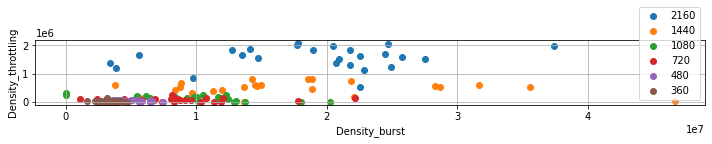

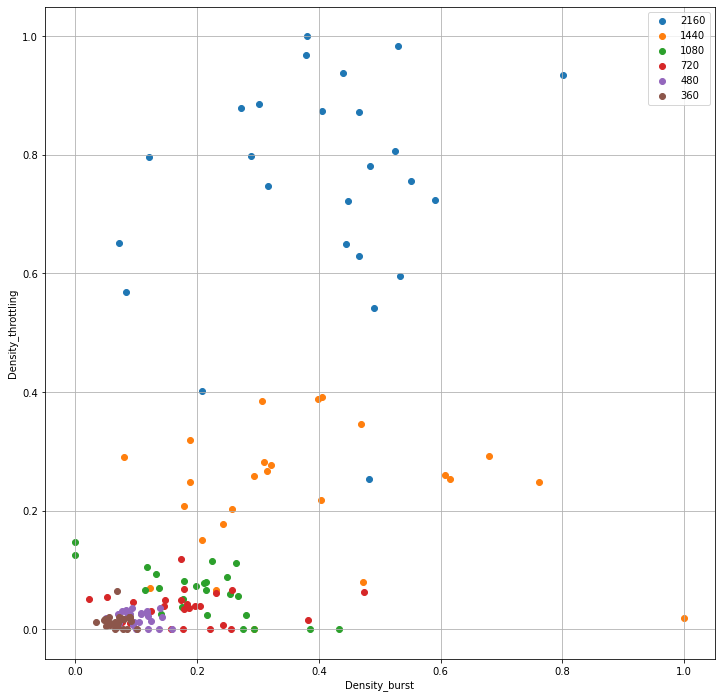

In [66]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(1.2)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data_norm)):
        if data['Quality'][i] == quality:
            x.append(data_norm['Density_burst'][i])
            y.append(data_norm['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

*По графикам можно понять отличие работы классификаторов с нормализацией и без*

**Снова пробуем KNN, но теперь с нормализованными данными**

In [53]:
X = data_norm[['Density_burst', 'Density_throttling']]
y = data_norm['Quality']

best_score = 0.0
i_best_score = 0
for i in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
    n_spaces = 1 - i // 10
    print(i, ' ' * n_spaces, scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        i_best_score = i

print("\nЛучший резульат:\nn =", i_best_score, "\naccuracy =", best_score)

1   0.6533333333333333
2   0.6733333333333335
3   0.7
4   0.6933333333333334
5   0.6733333333333333
6   0.68
7   0.6933333333333334
8   0.6799999999999999
9   0.6733333333333333
10  0.6733333333333333
11  0.6666666666666666
12  0.6599999999999999
13  0.6533333333333332
14  0.6733333333333333
15  0.6533333333333333
16  0.64
17  0.62
18  0.64
19  0.6399999999999999
20  0.6599999999999999
21  0.64
22  0.6466666666666667
23  0.6466666666666666
24  0.6666666666666666
25  0.6666666666666667
26  0.6466666666666666
27  0.6399999999999999
28  0.6466666666666666
29  0.6533333333333333

Лучший резульат:
n = 3 
accuracy = 0.7


*По сравнению с ненормированным KNN точность увеличилась значительно — 0.7 против 0.52*

**Пробуем Support Vector Classification**

In [58]:
best_score = 0.0
best_kernel = ''
for i_kernel in (['linear', 'poly', 'rbf', 'sigmoid']):
    X_norm = data_norm[['Density_burst', 'Density_throttling']]
    y_norm = data_norm['Quality']
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=i_kernel))
    scores = cross_val_score(clf, X_norm, y_norm, cv=10, scoring = 'accuracy')
    n_spaces = 8 - len(i_kernel)
    print('kernel:', i_kernel, ' ' * n_spaces, 'scores_mean:', scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        best_kernel = i_kernel
        
print("\nЛучший резульат:\nkernel = ", best_kernel, "\naccuracy = ", best_score)

kernel: linear    scores_mean: 0.68
kernel: poly      scores_mean: 0.5666666666666667
kernel: rbf       scores_mean: 0.66
kernel: sigmoid   scores_mean: 0.4133333333333334

Лучший резульат:
kernel =  linear 
accuracy =  0.68


*Получаем более слабый, чем для KNN, результат*

**Пробуем CatBoost**

In [49]:
best_score = 0.0
best_params = []
for iter_param in ([100, 200, 500, 1000, 2000]):
    for cv_param in ([5, 10, 20]):
        for lr_param in ([0.05, 0.2, 0.5, 0.7, 1]):
            model = CatBoostClassifier(iterations=iter_param, learning_rate = lr_param, silent=True)
            scores = cross_val_score(model, X, y, cv=cv_param, scoring = 'accuracy')
            n_spaces_i = 1 - iter_param // 1000
            n_spaces_j = 1 - cv_param // 10
            n_spaces_k = 5 - len(str(lr_param))
            print('iterations:', iter_param, ' ' * n_spaces_i,
                  'cv:', cv_param, ' ' * n_spaces_j,
                  'learning_rate:', lr_param,' ' * n_spaces_k,
                  'scores_mean:', scores.mean())
            if (scores.mean() > best_score):
                best_score = scores.mean()
                best_params = [iter_param, cv_param, lr_param]

print("\nЛучший резульат:",
      "\niterations = ", best_params[0],
      "\ncv = ", best_params[1],
      "\nlearning_rate = ", best_params[2],
      "\naccuracy = ", best_score, sep = "")

iterations: 100   cv: 5   learning_rate: 0.05   scores_mean: 0.7133333333333333
iterations: 100   cv: 5   learning_rate: 0.2    scores_mean: 0.7466666666666667
iterations: 100   cv: 5   learning_rate: 0.5    scores_mean: 0.72
iterations: 100   cv: 5   learning_rate: 0.7    scores_mean: 0.6933333333333334
iterations: 100   cv: 5   learning_rate: 1      scores_mean: 0.7066666666666667
iterations: 100   cv: 10  learning_rate: 0.05   scores_mean: 0.7
iterations: 100   cv: 10  learning_rate: 0.2    scores_mean: 0.7333333333333334
iterations: 100   cv: 10  learning_rate: 0.5    scores_mean: 0.7133333333333333
iterations: 100   cv: 10  learning_rate: 0.7    scores_mean: 0.7133333333333334
iterations: 100   cv: 10  learning_rate: 1      scores_mean: 0.7066666666666667
iterations: 100   cv: 20  learning_rate: 0.05   scores_mean: 0.7616071428571429
iterations: 100   cv: 20  learning_rate: 0.2    scores_mean: 0.7428571428571428
iterations: 100   cv: 20  learning_rate: 0.5    scores_mean: 0.723214

*Получили лучший результат на данном эксперименте — 0.776*